In [2]:
from comet_ml import Experiment
experiment = Experiment(
    api_key="2PoVCksa2Ak6yyjIKOZ7nlzto",
    project_name="igtc-project",
    workspace="tci",
)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/tci/igtc-project/91a927c820964d19882951529a0454cc
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (53.86 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     os packages              : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/tci/igtc-project/5443c1ded4b649a582d4b1f9dddc49d6



In [4]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow_text as text
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
tf.get_logger().setLevel("ERROR")

In [4]:
!nvidia-smi

Mon Sep 20 17:39:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data prep

In [6]:
root_dir = "../data"
sub_root_dir = os.path.join(root_dir, "gt_processed")
images_dir = os.path.join(sub_root_dir, "images")
tfrecords_dir = os.path.join(sub_root_dir, "tfrecords")
lp_file = os.path.join(sub_root_dir, "correct_data.json")

In [7]:


with open(lp_file, "r") as f:
    annotations = json.load(f)["annotations"]

image_path_to_lp = collections.defaultdict(list)

for element in annotations:
    postocr = f"{element['postocr']}"
    gt = f"{element['gt']}"
    image_path = os.path.join(images_dir, element["image"])
#     image_path_to_lp[image_path].append(postocr)
    image_path_to_lp[image_path].append(gt)


image_paths = list(image_path_to_lp.keys())
print(f"Number of images: {len(image_paths)}")

Number of images: 11400


In [8]:
train_size = 9000
valid_size = len(image_paths) - train_size
lps_per_image = 2
train_images_per_file = 3000
valid_images_per_file = 800

train_image_paths = image_paths[:train_size]
num_train_files = int(np.ceil(train_size / train_images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, "train")

valid_image_paths = image_paths[-valid_size:]
num_valid_files = int(np.ceil(valid_size / valid_images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, "valid")

In [9]:
tf.io.gfile.makedirs(tfrecords_dir)


def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def create_feature(image_path, lp):
    feature = {
        "lp": bytes_feature(lp.encode()),
        "image": bytes_feature(tf.io.read_file(image_path).numpy()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def write_tfrecords(file_name, image_paths):
    lp_list = []
    image_path_list = []
    for image_path in image_paths:
        lps = image_path_to_lp[image_path]
        lp_list.extend(lps)
        image_path_list.extend([image_path] * len(lps))
    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_path_list)):
            example = create_feature(
                image_path_list[example_idx], lp_list[example_idx]
            )
            writer.write(example.SerializeToString())
    return example_idx + 1


def write_data(image_paths, num_files, files_prefix, images_per_file):
    example_counter = 0
    for file_idx in tqdm(range(num_files)):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = images_per_file * file_idx
        end_idx = start_idx + images_per_file
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
    return example_counter


In [68]:
train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix, train_images_per_file)
valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix, valid_images_per_file)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


# Model

In [10]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

In [11]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    xception = keras.applications.Xception(
        include_top=False, weights="imagenet", pooling="avg"
    )
    for layer in xception.layers:
        layer.trainable = trainable
    inputs = layers.Input(shape=(299, 299, 3), name="image_input")
    xception_input = tf.keras.applications.xception.preprocess_input(inputs)
    embeddings = xception(xception_input)
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    return keras.Model(inputs, outputs, name="vision_encoder")

In [12]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    preprocess = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2",
        name="text_preprocessing",
    )
    bert = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
        "bert",
    )
    bert.trainable = trainable
    inputs = layers.Input(shape=(), dtype=tf.string, name="text_input")
    bert_inputs = preprocess(inputs)
    embeddings = bert(bert_inputs)["pooled_output"]
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    return keras.Model(inputs, outputs, name="text_encoder")

In [13]:
class IGTCPreTrainer(keras.Model):
    def __init__(self, text_encoder, image_encoder, **kwargs):
        super(IGTCPreTrainer, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temp = tf.Variable(1.)
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        lp_embeddings = text_encoder(features["lp"], training=training)
        image_embeddings = vision_encoder(features["image"], training=training)
        return lp_embeddings, image_embeddings, tf.math.exp(tf.math.scalar_mul(self.temp, tf.math.log(1/0.07)))

    def compute_loss(self, lp_embeddings, image_embeddings, logit_scale):
        logits = (
            tf.matmul(lp_embeddings, image_embeddings, transpose_b=True)
            * logit_scale
        )
        images_similarity = tf.matmul(
            image_embeddings, image_embeddings, transpose_b=True
        )
        lp_similarity = tf.matmul(
            lp_embeddings, lp_embeddings, transpose_b=True
        )
        targets = keras.activations.softmax(
            (lp_similarity + images_similarity) / 2
        )
        lp_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        images_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        return (lp_loss + images_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            lp_embeddings, image_embeddings, logit_scale = self(features, training=True)
            logit_scale = tf.clip_by_value(logit_scale, clip_value_min=0, clip_value_max=4.6052)
            loss = self.compute_loss(lp_embeddings, image_embeddings, logit_scale)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
 
    def test_step(self, features):
        lp_embeddings, image_embeddings, logit_scale = self(features, training=False)
        logit_scale = tf.clip_by_value(logit_scale, clip_value_min=0, clip_value_max=4.6052)
        loss = self.compute_loss(lp_embeddings, image_embeddings, logit_scale)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [14]:
num_epochs = 5
batch_size = 128

In [15]:
vision_encoder = create_vision_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.2)
text_encoder = create_text_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1)
pretrainer = IGTCPreTrainer(text_encoder, vision_encoder)
pretrainer.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)
)

2021-09-20 20:09:22.296712: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-20 20:09:22.297947: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-20 20:09:22.350867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 20:09:22.351852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-09-20 20:09:22.351886: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-20 20:09:22.354815: I tensorflow/stream_executor/platform/defau

In [16]:
def decode_fn(sample):
    features = tf.io.parse_single_example(
        sample,
        {
           "lp": tf.io.FixedLenFeature([], dtype=tf.string),
           "image": tf.io.FixedLenFeature([], dtype=tf.string)
        }
    )
    features['image'] = tf.io.decode_jpeg(
        features['image'], channels=3
    )
    return features
    

def fetch_dataset_tfrecord(string_pattern, batch_size, shuffle_size):
    return (
        tf.data.TFRecordDataset(
            tf.data.Dataset.list_files(string_pattern))
        .map(decode_fn, num_parallel_calls=8)
        .shuffle(shuffle_size)
        .batch(batch_size)
    )

In [17]:
train_dataset = fetch_dataset_tfrecord(
    os.path.join(tfrecords_dir, "train-*.tfrecord"),
    batch_size,
    train_size
)
valid_dataset = fetch_dataset_tfrecord(
    os.path.join(tfrecords_dir, "valid-*.tfrecord"),
    batch_size,
    valid_size
)

In [16]:
reduce_learningRate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='clipPretrained_model_{epoch:02d}-{val_loss:.2f}.h5')

history = pretrainer.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=[reduce_learningRate, model_checkpoint]
)

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging
COMET WARNING: An unknown exception happened in Keras callback on_train_begin; ignoring


Epoch 1/5


2021-09-19 12:17:52.492180: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-19 12:17:53.319774: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-19 12:17:53.757498: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


71/71 [==============================] - 109s 1s/step - loss: 34.1872 - val_loss: 8.7790
Epoch 2/5
71/71 [==============================] - 96s 1s/step - loss: 9.6586 - val_loss: 5.5656
Epoch 3/5
71/71 [==============================] - 97s 1s/step - loss: 5.7642 - val_loss: 4.9615
Epoch 4/5
71/71 [==============================] - 96s 1s/step - loss: 5.0905 - val_loss: 4.9091
Epoch 5/5
71/71 [==============================] - 96s 1s/step - loss: 4.9306 - val_loss: 4.8895


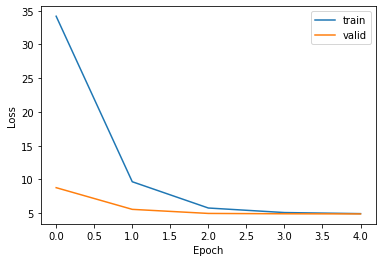

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [25]:
pretrainer = tf.keras.models.load_model('experiments/clipPretrained_model_05-4.89.h5')

OSError: SavedModel file does not exist at: experiments/clipPretrained_model_05-4.89.h5/{saved_model.pbtxt|saved_model.pb}

In [20]:
train_dataset

<BatchDataset shapes: {image: (None, None, None, 3), lp: (None,)}, types: {image: tf.uint8, lp: tf.string}>